## Notebook to process LAU and NUTS shapefile to parquet

In [10]:
# Load software
import os
import pathlib
import sys
import json
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from dotenv import load_dotenv
import math
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
import rioxarray as rio

# Import custom functionality
from coclicodata.drive_config import p_drive

# Define (local and) remote drives
coclico_data_dir = p_drive.joinpath("11207608-coclico", "FASTTRACK_DATA")

In [11]:
# Set path to geopackage
LAU_dir = coclico_data_dir.joinpath('XX_LAU')
NUTS_dir = coclico_data_dir.joinpath('XX_NUTS')

LAU_file = LAU_dir.joinpath('LAU_RG_01M_2020_3035.shp')
NUTS_file = NUTS_dir.joinpath('NUTS_RG_01M_2021_3035.shp')

In [12]:
# Load data
LAU = gpd.read_file(LAU_file)

In [13]:
# Load data
NUTS = gpd.read_file(NUTS_file) 

In [14]:
LAU

,GISCO_ID,CNTR_CODE,LAU_ID,LAU_NAME,POP_2020,POP_DENS_2,AREA_KM2,YEAR,FID,geometry
0,CZ_579475,CZ,579475,Libňatov,363.0,62.240158,5.832247,2020,CZ_579475,"POLYGON ((4747705.585 3057545.260, 4746836.524..."
1,CZ_579483,CZ,579483,Libotov,178.0,41.774759,4.260946,2020,CZ_579483,"POLYGON ((4731662.418 3049054.578, 4732297.093..."
2,CZ_579491,CZ,579491,Vranov,181.0,37.408873,4.838424,2020,CZ_579491,"POLYGON ((4540137.623 2963864.496, 4538706.113..."
3,CZ_579505,CZ,579505,Malá Úpa,142.0,5.318510,26.699207,2020,CZ_579505,"POLYGON ((4730399.261 3087673.334, 4730914.253..."
4,AT_41004,AT,41004,Eggendorf im Traunkreis,1041.0,116.481747,8.937023,2020,AT_41004,"POLYGON ((4631543.792 2788412.230, 4630476.583..."
...,...,...,...,...,...,...,...,...,...,...
98608,SK_599816,SK,599816,Košice - mestská časť Nad jazerom,24443.0,6686.211551,3.655732,2020,SK_599816,"POLYGON ((5149120.507 2905279.350, 5150154.014..."
98609,SK_599824,SK,599824,Košice - mestská časť Juh,22692.0,2324.881955,9.760496,2020,SK_599824,"POLYGON ((5144451.048 2904986.166, 5144591.047..."
98610,SK_599841,SK,599841,Košice - mestská časť Šaca,5969.0,124.672777,47.877333,2020,SK_599841,"POLYGON ((5141041.890 2900350.394, 5144604.564..."
98611,SK_599859,SK,599859,Košice - mestská časť Poľov,1219.0,94.049511,12.961258,2020,SK_599859,"POLYGON ((5141041.890 2900350.394, 5141299.765..."


In [15]:
NUTS

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
0,AL,0,AL,b'5368716970eb726961',b'5368716970eb726961',0.0,0,0,"MULTIPOLYGON (((5121233.536 2221719.441, 51208..."
1,CZ,0,CZ,?esko,?esko,0.0,0,0,"POLYGON ((4624843.654 3112209.741, 4625546.618..."
2,DE,0,DE,Deutschland,Deutschland,0.0,0,0,"MULTIPOLYGON (((4355225.365 2715902.993, 43541..."
3,DK,0,DK,Danmark,Danmark,0.0,0,0,"MULTIPOLYGON (((4650502.736 3591342.844, 46503..."
4,CY,0,CY,b'4bfd70726f73',??????,0.0,0,0,"MULTIPOLYGON (((6527040.718 1762367.593, 65267..."
...,...,...,...,...,...,...,...,...,...
2005,NO0B1,3,NO,Jan Mayen,Jan Mayen,3.0,3,1,"POLYGON ((3623747.621 5400386.841, 3624031.138..."
2006,EE009,3,EE,Kesk-Eesti,Kesk-Eesti,4.0,3,1,"MULTIPOLYGON (((5216227.688 4159212.769, 52172..."
2007,NO0,1,NO,Norge,Norge,0.0,0,0,"MULTIPOLYGON (((4961367.759 5413266.131, 49622..."
2008,NO0B,2,NO,Jan Mayen and Svalbard,Jan Mayen and Svalbard,NaN,0,0,"MULTIPOLYGON (((4744650.828 6379141.635, 47446..."


In [16]:
# Write data as parquet file
lau_parquet_file = str(LAU_file).replace('.shp','.parquet')
LAU.to_parquet(lau_parquet_file)

nuts_parquet_file = str(NUTS_file).replace('.shp','.parquet')
NUTS.to_parquet(nuts_parquet_file)

In [9]:
nuts_parquet_file

'P:\\11207608-coclico\\FASTTRACK_DATA\\XX_NUTS\\NUTS_RG_01M_2021_3035.parquet'

In [14]:
# Test new parquet file
test_parquet = pd.read_parquet(lau_parquet_file)
test_parquet

,GISCO_ID,CNTR_CODE,LAU_ID,LAU_NAME,POP_2020,POP_DENS_2,AREA_KM2,YEAR,FID,geometry
0,CZ_579475,CZ,579475,Libňatov,363.0,62.240158,5.832247,2020,CZ_579475,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0b\x00...
1,CZ_579483,CZ,579483,Libotov,178.0,41.774759,4.260946,2020,CZ_579483,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00...
2,CZ_579491,CZ,579491,Vranov,181.0,37.408873,4.838424,2020,CZ_579491,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x...
3,CZ_579505,CZ,579505,Malá Úpa,142.0,5.318510,26.699207,2020,CZ_579505,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x17\x00...
4,AT_41004,AT,41004,Eggendorf im Traunkreis,1041.0,116.481747,8.937023,2020,AT_41004,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0b\x00..."
...,...,...,...,...,...,...,...,...,...,...
98608,SK_599816,SK,599816,Košice - mestská časť Nad jazerom,24443.0,6686.211551,3.655732,2020,SK_599816,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x..."
98609,SK_599824,SK,599824,Košice - mestská časť Juh,22692.0,2324.881955,9.760496,2020,SK_599824,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00...
98610,SK_599841,SK,599841,Košice - mestská časť Šaca,5969.0,124.672777,47.877333,2020,SK_599841,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1d\x00...
98611,SK_599859,SK,599859,Košice - mestská časť Poľov,1219.0,94.049511,12.961258,2020,SK_599859,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0e\x00...


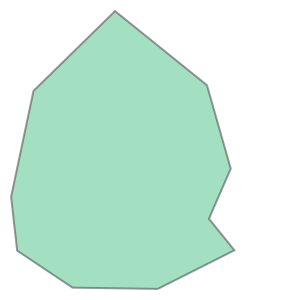

In [18]:
import shapely
shapely.Polygon(LAU.geometry[0])